# Loan fraud detection

This data set was uploaded in kaggle https://www.kaggle.com/mishra5001/credit-card to get the insights of 
Credit card Defaultees based on an extensive collection of attributes.
It was offered as a case study for EDA in a real business scenario to give basic understanding of risk analytics in banking and financial services, and understand how data is used to minimize the risk of losing money while lending to customers.
I took this dataset to challenge myself in a machine learning classification scenario, with a huge imbalanced data. During this notebook you will see two approaches: One favoring the preservation of more costumers in the data and other favoring the preservation of more features.

## Setting up

In [1]:
#imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import requests
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
#parameters for pandas
pd.set_option('display.max_columns', None)

In [3]:
#parameters for matplotlib
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.figsize"] = [14,9]

In [4]:
#Generating the scorecard
scorecard = pd.DataFrame(columns =['classifier','train_acc_score','test_acc_score','roc_auc_score','precision','recall',
                                          'true_neg','false_pos', 'false_neg', 'true_pos'])

In [5]:
#Confusion matrix and score generation
def confmetrics(var,gftitle,*args):
    global scorecard
    #GENERATING METRICS
    y_var_tpred = var.predict(X_train)
    y_var_pred = var.predict(X_test)
    var_train_acc = accuracy_score(y_train, y_var_tpred)
    var_test_acc = accuracy_score(y_test, y_var_pred)
    var_roc_auc_score = roc_auc_score(y_test, var.predict_proba(X_test)[:, 1])
    var_precision_score = precision_score(y_test, y_var_pred,average='binary')
    var_recall_score = recall_score(y_test, y_var_pred,average='binary')
    #GENERATING CONFUSION MATRIX
    var_cf_matrix = confusion_matrix(y_test, y_var_pred)
    plt.figure(figsize=[8,5])
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                var_cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     var_cf_matrix.flatten()/np.sum(var_cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(var_cf_matrix, annot=labels, fmt='',
            cmap='coolwarm').set_title(gftitle)
    plt.show()
    #PRINTING METRICS
    print('='*80)
    print('Train Accuracy : ',var_train_acc)
    print('Test Accuracy  : ',var_test_acc)
    print('ROC AUC Score  : ',var_roc_auc_score)
    print('Precision Score: ',var_precision_score)
    print('Recall Score   : ',var_recall_score)
    #Adding to the Scorecard
    if args:
        scorecard = scorecard.append(pd.Series([args[0],var_train_acc,var_test_acc,var_roc_auc_score,var_precision_score,var_recall_score,
                                (var_cf_matrix.flatten()/np.sum(var_cf_matrix))[0],
                                (var_cf_matrix.flatten()/np.sum(var_cf_matrix))[1],
                                (var_cf_matrix.flatten()/np.sum(var_cf_matrix))[2],
                                (var_cf_matrix.flatten()/np.sum(var_cf_matrix))[3]],index=scorecard.columns),ignore_index=True)

## First look at the dataset

In [6]:
#opening the file
df = pd.read_csv('application_data.zip')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.0,270000.0,513531.0,808650.0,4050000.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,0.007000,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [9]:
df.shape

(307511, 122)

## Cleaning

The dataset has 307511 rows, and 122 features, but we will find 3 issues here:
- No clear description of the feature on the dataset documentation,
- Lots of NaN values. Some features have roughly 31% of data.
- A boatload of descriptive features of costumer housing.

For my first approach, I´ll drop these features to get the first insights without sacrifying too many costumer applications.

### First Pass

In [10]:
#Check for nan or missing data
df.isna().sum().sort_values(ascending=False)

COMMONAREA_MEDI                214865
COMMONAREA_AVG                 214865
COMMONAREA_MODE                214865
NONLIVINGAPARTMENTS_MODE       213514
NONLIVINGAPARTMENTS_MEDI       213514
                                ...  
REG_CITY_NOT_LIVE_CITY              0
LIVE_REGION_NOT_WORK_REGION         0
REG_REGION_NOT_WORK_REGION          0
HOUR_APPR_PROCESS_START             0
SK_ID_CURR                          0
Length: 122, dtype: int64

In [11]:
#Dropping colunms with too many NaN results and without description.
coldrops = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 
            'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
            'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
            'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
            'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'HOUSETYPE_MODE', 'NAME_TYPE_SUITE', 'REGION_RATING_CLIENT', 
            'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1',
            'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 
            'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
            'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
            'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
            'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
            'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
            'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 
            'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 
            'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'TOTALAREA_MODE', 
            'AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON',
            'AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
            'OWN_CAR_AGE', 'FLAG_MOBIL', 'REGION_POPULATION_RELATIVE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 
            'FLAG_PHONE','DAYS_LAST_PHONE_CHANGE','REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
            'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE'
            ]
df = df.drop(columns=coldrops)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,CNT_FAM_MEMBERS,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-9461,-637,-3648.0,-2120,1,1.0,0,0,2.0,2.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,-16765,-1188,-1186.0,-291,1,2.0,0,0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-19046,-225,-4260.0,-2531,1,1.0,0,0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-19005,-3039,-9833.0,-2437,1,2.0,0,0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-19932,-3038,-4311.0,-3458,1,1.0,0,0,0.0,0.0


In [12]:
df.shape

(307511, 25)

### 2nd Pass for missing or "weird" data

In [13]:
df.isna().sum().sort_values(ascending=False)

DEF_60_CNT_SOCIAL_CIRCLE      1021
DEF_30_CNT_SOCIAL_CIRCLE      1021
AMT_GOODS_PRICE                278
AMT_ANNUITY                     12
CNT_FAM_MEMBERS                  2
TARGET                           0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
CNT_CHILDREN                     0
AMT_INCOME_TOTAL                 0
AMT_CREDIT                       0
NAME_EDUCATION_TYPE              0
NAME_INCOME_TYPE                 0
NAME_FAMILY_STATUS               0
NAME_HOUSING_TYPE                0
DAYS_BIRTH                       0
DAYS_EMPLOYED                    0
DAYS_REGISTRATION                0
DAYS_ID_PUBLISH                  0
FLAG_CONT_MOBILE                 0
REG_REGION_NOT_LIVE_REGION       0
REG_CITY_NOT_LIVE_CITY           0
SK_ID_CURR                       0
dtype: int64

Now that we have few missing values, it is acceptable to drop them.

In [14]:
#Drop NA
df = df.dropna()

#### The gender feature

In [15]:
df['CODE_GENDER'].value_counts()

F      201596
M      104600
XNA         4
Name: CODE_GENDER, dtype: int64

It´s 2021. I´m not going to assume the gender of these people.

In [16]:
df = df[df['CODE_GENDER'] != 'XNA']

In [17]:
df.shape

(306196, 25)

#### The age feature

In [18]:
df['DAYS_BIRTH'].value_counts()

-13749    43
-13481    42
-10020    41
-18248    41
-10292    40
          ..
-7934      1
-24902     1
-7891      1
-24615     1
-7673      1
Name: DAYS_BIRTH, Length: 17460, dtype: int64

To ease EDA, I´ll change the DAYS_BIRTH feature to the real AGE of the costumer.

In [19]:
def convertdaystoage(valor):
    valor = int(-valor / 365.2425)
    return valor

#Changing DAYS_BIRTH to AGE
df.DAYS_BIRTH = df.DAYS_BIRTH / -365.2425
df.DAYS_BIRTH = df.DAYS_BIRTH.astype(int)
df.rename(columns={'DAYS_BIRTH': 'AGE'}, inplace=True)

In [20]:
df['AGE'].value_counts()

38    8872
37    8757
39    8697
36    8611
40    8599
27    8509
41    8449
31    8381
43    8253
42    8161
28    7961
32    7876
44    7764
30    7745
35    7724
33    7693
29    7651
34    7635
54    7586
53    7432
45    7236
46    7225
47    6982
48    6954
56    6843
52    6766
57    6723
51    6702
59    6659
49    6658
55    6499
50    6376
58    6231
60    6144
62    5497
61    5375
63    5156
64    5130
26    4522
25    4156
23    4052
24    3900
65    3008
22    2934
67    2078
66    2036
21    1236
68     760
69       1
20       1
Name: AGE, dtype: int64

#### Negative days
No need to keep days in a negative value. Converting to the absolute

In [21]:
#Changing negative values on DAYS collumns
days_cols=[x for x in df if x.startswith('DAYS')] 
df[days_cols]= abs(df[days_cols])

In [22]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,CNT_FAM_MEMBERS,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,25,637.0,3648.0,2120.0,1,1.0,0,0,2.0,2.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,45,1188.0,1186.0,291.0,1,2.0,0,0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,52,225.0,4260.0,2531.0,1,1.0,0,0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,52,3039.0,9833.0,2437.0,1,2.0,0,0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,54,3038.0,4311.0,3458.0,1,1.0,0,0,0.0,0.0


In [23]:
df.isna().sum()

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
AMT_CREDIT                    0
AMT_ANNUITY                   0
AMT_GOODS_PRICE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
AGE                           0
DAYS_EMPLOYED                 0
DAYS_REGISTRATION             0
DAYS_ID_PUBLISH               0
FLAG_CONT_MOBILE              0
CNT_FAM_MEMBERS               0
REG_REGION_NOT_LIVE_REGION    0
REG_CITY_NOT_LIVE_CITY        0
DEF_30_CNT_SOCIAL_CIRCLE      0
DEF_60_CNT_SOCIAL_CIRCLE      0
dtype: int64

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,306196.0,278170.513227,102786.140703,100002.0,189137.75,278197.5,367120.25,456255.0
TARGET,306196.0,0.080889,0.272666,0.0,0.00,0.0,0.00,1.0
CNT_CHILDREN,306196.0,0.417096,0.722194,0.0,0.00,0.0,1.00,19.0
AMT_INCOME_TOTAL,306196.0,168664.439824,237364.314087,25650.0,112500.00,146250.0,202500.00,117000000.0
AMT_CREDIT,306196.0,599801.234103,402578.563667,45000.0,270000.00,517500.0,808650.00,4050000.0
AMT_ANNUITY,306196.0,27135.130519,14477.434025,1615.5,16573.50,24939.0,34600.50,258025.5
AMT_GOODS_PRICE,306196.0,538678.047711,369459.193287,40500.0,238500.00,450000.0,679500.00,4050000.0
AGE,306196.0,43.413000,11.944607,20.0,33.00,43.0,53.00,69.0
DAYS_EMPLOYED,306196.0,67775.668346,139485.859079,0.0,933.00,2220.0,5714.00,365243.0
DAYS_REGISTRATION,306196.0,4986.246757,3522.943923,0.0,2010.00,4504.0,7479.00,24672.0


#### Exporting for EDA

In [25]:
#Exporting
df.to_csv('postclean.csv.zip', index=False, compression='zip')

## EDA

In [26]:
df_clean = pd.read_csv('postclean.csv.zip')
df_clean.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,CNT_FAM_MEMBERS,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,25,637.0,3648.0,2120.0,1,1.0,0,0,2.0,2.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,45,1188.0,1186.0,291.0,1,2.0,0,0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,52,225.0,4260.0,2531.0,1,1.0,0,0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,52,3039.0,9833.0,2437.0,1,2.0,0,0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,54,3038.0,4311.0,3458.0,1,1.0,0,0,0.0,0.0


### First Impressions

#### Binning
I´m going to bin the income of the costumers based on the dataset quantiles and values to get a few insights.

In [27]:
# binning AMT_INCOME_TOTAL column based on quantiles
df_clean['AMT_INCOME_QRANGE'] = pd.qcut(df_clean.AMT_INCOME_TOTAL, q=[0,0.2,0.4,0.6,0.8,1], labels=['VERY LOW','LOW','MEDIUM','HIGH','VERY HIGH'])
df_clean.AMT_INCOME_QRANGE.value_counts()

LOW          85428
HIGH         75217
VERY LOW     63386
VERY HIGH    46827
MEDIUM       35338
Name: AMT_INCOME_QRANGE, dtype: int64

In [28]:
# binning AMT_INCOME_TOTAL column based on values
df_clean['AMT_INCOME_RANGE'] = pd.cut(df_clean.AMT_INCOME_TOTAL,bins=[0,50000,150000,300000,500000,1000000], labels=['VERY LOW','LOW','MEDIUM','HIGH','VERY HIGH'])
df_clean.AMT_INCOME_RANGE.value_counts()

LOW          150162
MEDIUM       128985
HIGH          19898
VERY LOW       4502
VERY HIGH      2405
Name: AMT_INCOME_RANGE, dtype: int64

#### The TARGET Variable

In [29]:
#Analysing the TARGET variable
df_clean.TARGET.value_counts() # 1 - Client with payment difficulties, 0 -- Client with no payment difficulties

0    281428
1     24768
Name: TARGET, dtype: int64

In [30]:
#Segmenting the data frame based on the target variable
df_target0 = df_clean.loc[df_clean.TARGET==0]
df_target1 = df_clean.loc[df_clean.TARGET==1]

In [31]:
print(df_target0.shape)
print(df_target1.shape)

(281428, 27)
(24768, 27)


In [32]:
#Finding the imbalance ratio for the TARGET variable
round(len(df_target0)/len(df_target1),2)

11.36

TARGET data is very disbalanced. I´ll probably encounter issues further on the Machine Learning steps

## Plotting

#### Categorical TARGET data distribution
- 0 - Client without payment difficulties
- 1 - Client with payment difficulties

##### By EDUCATION TYPE

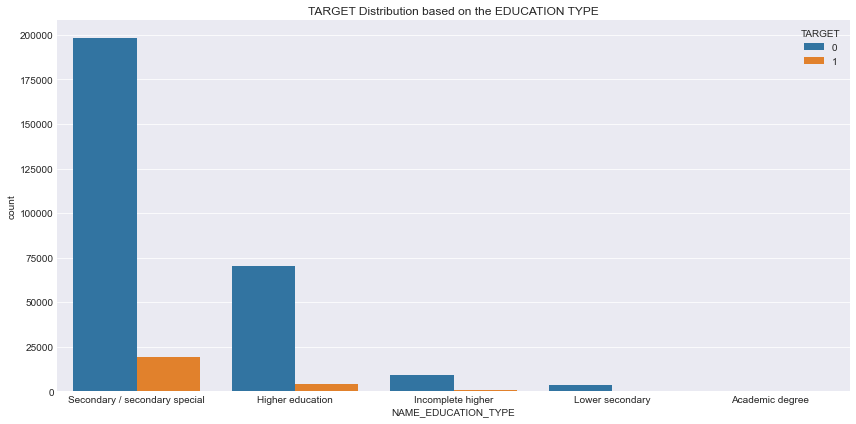

In [33]:
plt.figure(figsize=[12,6])
sns.countplot(data=df_clean,x = 'NAME_EDUCATION_TYPE', order = df_clean['NAME_EDUCATION_TYPE'].value_counts().index,
              hue='TARGET').set_title('TARGET Distribution based on the EDUCATION TYPE')
plt.tight_layout()
plt.show()

##### By INCOME QRANGE

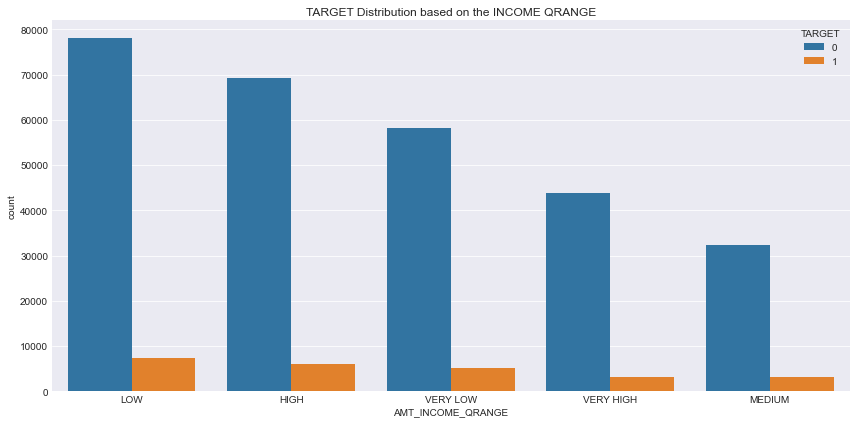

In [34]:
plt.figure(figsize=[12,6])
sns.countplot(data=df_clean,x = 'AMT_INCOME_QRANGE', order = df_clean['AMT_INCOME_QRANGE'].value_counts().index,
              hue='TARGET').set_title('TARGET Distribution based on the INCOME QRANGE')
plt.tight_layout()
plt.show()

##### By INCOME RANGE

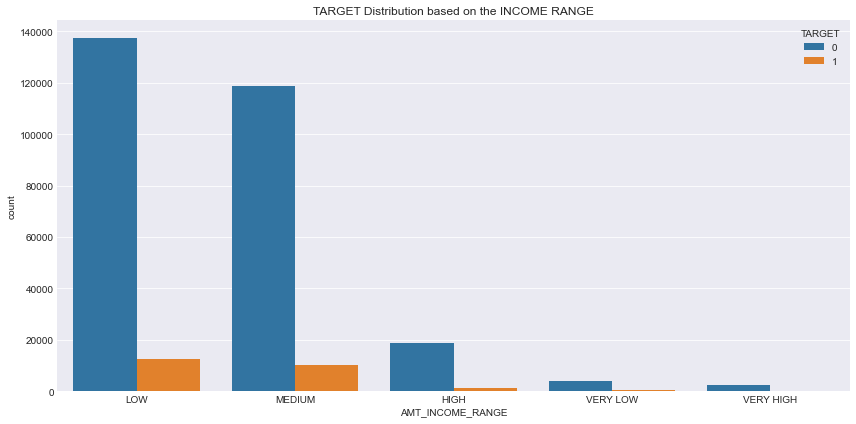

In [35]:
plt.figure(figsize=[12,6])
sns.countplot(data=df_clean,x = 'AMT_INCOME_RANGE', order = df_clean['AMT_INCOME_RANGE'].value_counts().index,
              hue='TARGET').set_title('TARGET Distribution based on the INCOME RANGE')
plt.tight_layout()
plt.show()

##### By HOUSING TYPE

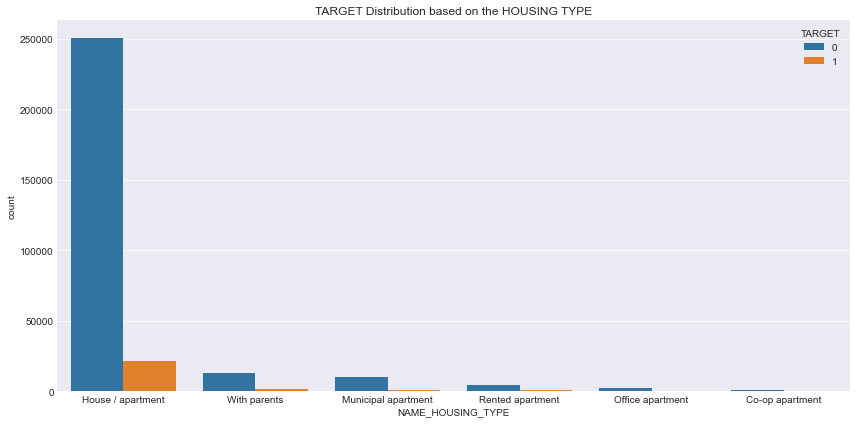

In [36]:
plt.figure(figsize=[12,6])
sns.countplot(data=df_clean,x = 'NAME_HOUSING_TYPE', order = df_clean['NAME_HOUSING_TYPE'].value_counts().index,
              hue='TARGET').set_title('TARGET Distribution based on the HOUSING TYPE')
plt.tight_layout()
plt.show()

##### By Family Status

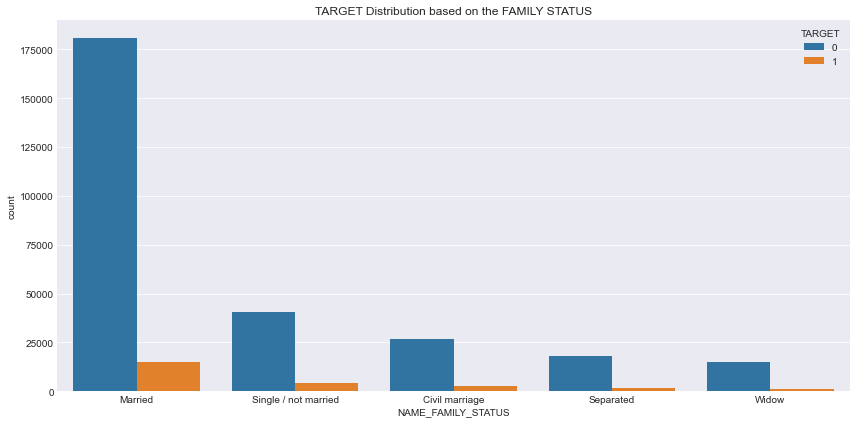

In [37]:
plt.figure(figsize=[12,6])
sns.countplot(data=df_clean,x = 'NAME_FAMILY_STATUS', order = df_clean['NAME_FAMILY_STATUS'].value_counts().index,
              hue='TARGET').set_title('TARGET Distribution based on the FAMILY STATUS')
plt.tight_layout()
plt.show()

##### By INCOME TYPE

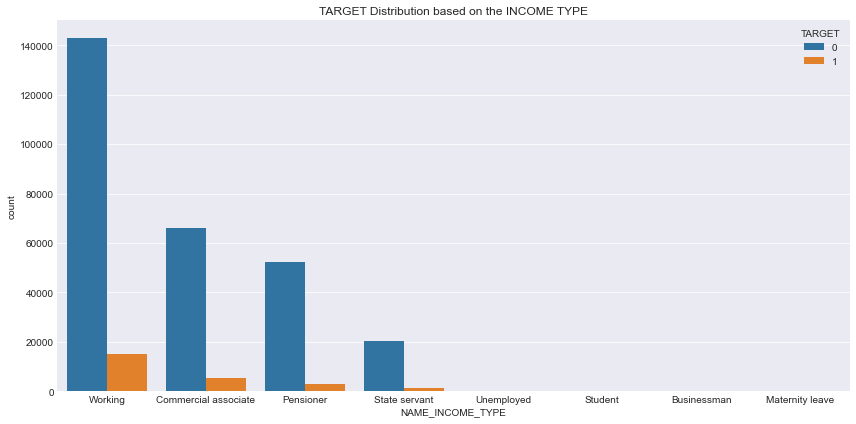

In [38]:
plt.figure(figsize=[12,6])
sns.countplot(data=df_clean,x = 'NAME_INCOME_TYPE', order = df_clean['NAME_INCOME_TYPE'].value_counts().index,
              hue='TARGET').set_title('TARGET Distribution based on the INCOME TYPE')
plt.tight_layout()
plt.show()

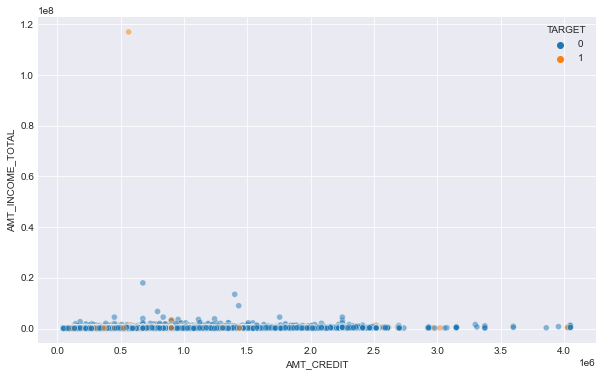

In [39]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=df_clean, x='AMT_CREDIT', y = 'AMT_INCOME_TOTAL', alpha=0.5, hue='TARGET')
plt.show()

#### Separating TARGET data

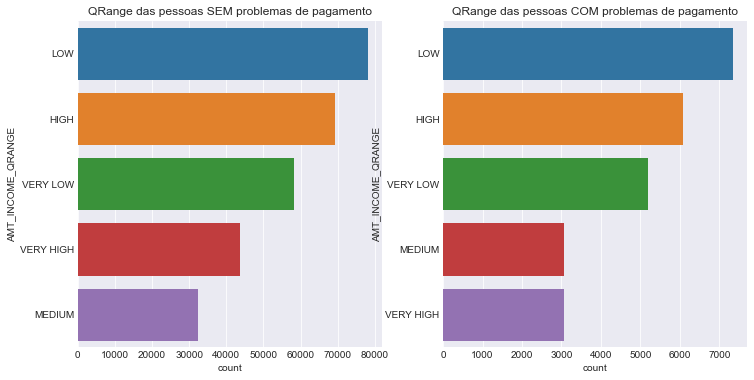

In [40]:
fig, ax =plt.subplots(1,2,figsize=[12,6])
sns.countplot(data=df_target0,y = 'AMT_INCOME_QRANGE',order = df_target0['AMT_INCOME_QRANGE'].value_counts().index,ax=ax[0])
sns.countplot(data=df_target1,y = 'AMT_INCOME_QRANGE',order = df_target1['AMT_INCOME_QRANGE'].value_counts().index,ax=ax[1])
ax[0].set_title('QRange das pessoas SEM problemas de pagamento')
ax[1].set_title('QRange das pessoas COM problemas de pagamento')
plt.show()

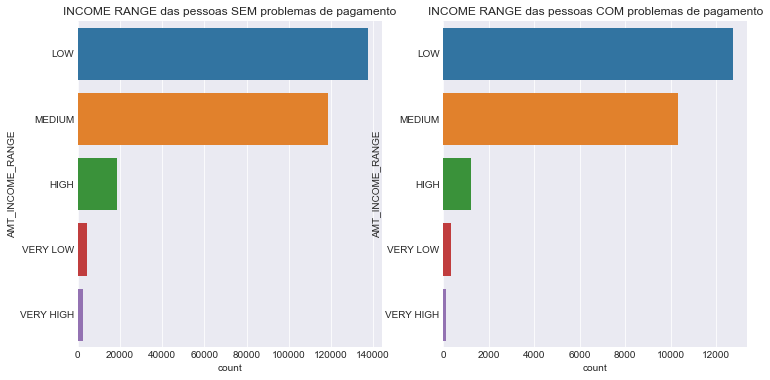

In [41]:
fig, ax =plt.subplots(1,2,figsize=[12,6])
sns.countplot(data=df_target0,y = 'AMT_INCOME_RANGE',order = df_target0['AMT_INCOME_RANGE'].value_counts().index,ax=ax[0])
sns.countplot(data=df_target1,y = 'AMT_INCOME_RANGE',order = df_target1['AMT_INCOME_RANGE'].value_counts().index,ax=ax[1])
ax[0].set_title('INCOME RANGE das pessoas SEM problemas de pagamento')
ax[1].set_title('INCOME RANGE das pessoas COM problemas de pagamento')
plt.show()

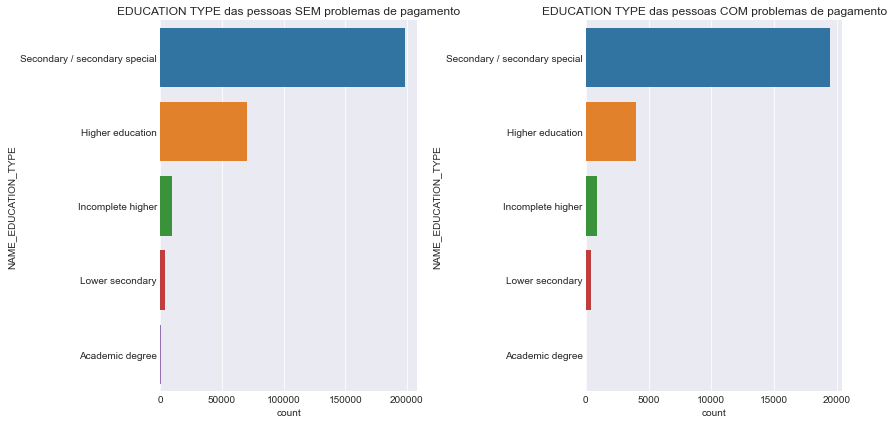

In [42]:
fig, ax =plt.subplots(1,2,figsize=[12,6])
sns.countplot(data=df_target0,y = 'NAME_EDUCATION_TYPE',order = df_target0['NAME_EDUCATION_TYPE'].value_counts().index,ax=ax[0])
sns.countplot(data=df_target1,y = 'NAME_EDUCATION_TYPE',order = df_target1['NAME_EDUCATION_TYPE'].value_counts().index,ax=ax[1])
ax[0].set_title('EDUCATION TYPE das pessoas SEM problemas de pagamento')
ax[1].set_title('EDUCATION TYPE das pessoas COM problemas de pagamento')
fig.tight_layout()
plt.show()

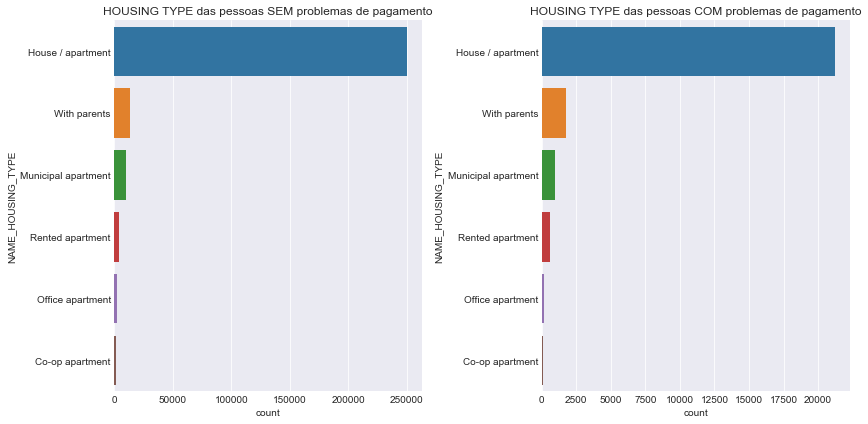

In [43]:
fig, ax =plt.subplots(1,2,figsize=[12,6])
sns.countplot(data=df_target0,y = 'NAME_HOUSING_TYPE', order = df_target0['NAME_HOUSING_TYPE'].value_counts().index,ax=ax[0])
sns.countplot(data=df_target1,y = 'NAME_HOUSING_TYPE', order = df_target1['NAME_HOUSING_TYPE'].value_counts().index,ax=ax[1])
ax[0].set_title('HOUSING TYPE das pessoas SEM problemas de pagamento')
ax[1].set_title('HOUSING TYPE das pessoas COM problemas de pagamento')
fig.tight_layout()
plt.show()

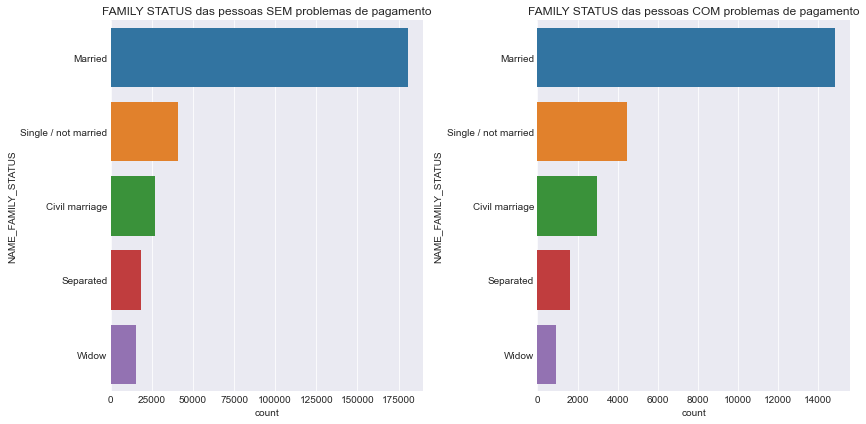

In [44]:
fig, ax =plt.subplots(1,2,figsize=[12,6])
sns.countplot(data=df_target0,y = 'NAME_FAMILY_STATUS', order = df_target0['NAME_FAMILY_STATUS'].value_counts().index,ax=ax[0])
sns.countplot(data=df_target1,y = 'NAME_FAMILY_STATUS', order = df_target1['NAME_FAMILY_STATUS'].value_counts().index,ax=ax[1])
ax[0].set_title('FAMILY STATUS das pessoas SEM problemas de pagamento')
ax[1].set_title('FAMILY STATUS das pessoas COM problemas de pagamento')
fig.tight_layout()
plt.show()

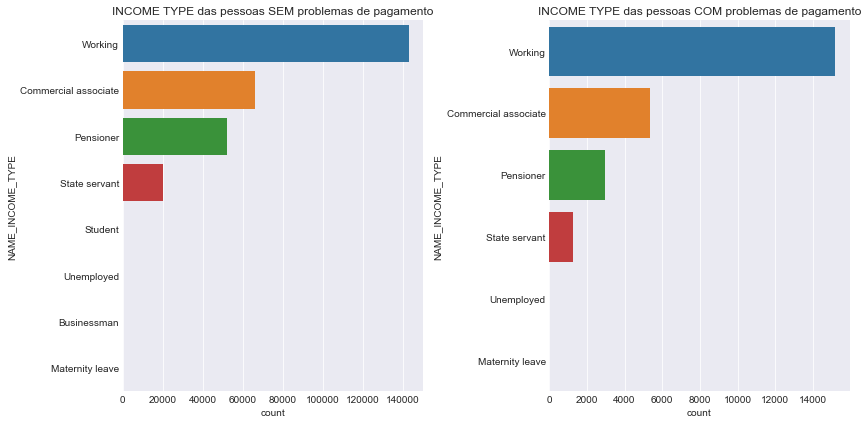

In [45]:
fig, ax =plt.subplots(1,2,figsize=[12,6])
sns.countplot(data=df_target0,y = 'NAME_INCOME_TYPE', order = df_target0['NAME_INCOME_TYPE'].value_counts().index,ax=ax[0])
sns.countplot(data=df_target1,y = 'NAME_INCOME_TYPE', order = df_target1['NAME_INCOME_TYPE'].value_counts().index,ax=ax[1])
ax[0].set_title('INCOME TYPE das pessoas SEM problemas de pagamento')
ax[1].set_title('INCOME TYPE das pessoas COM problemas de pagamento')
fig.tight_layout()
plt.show()

#### Income Range Gender Distribution

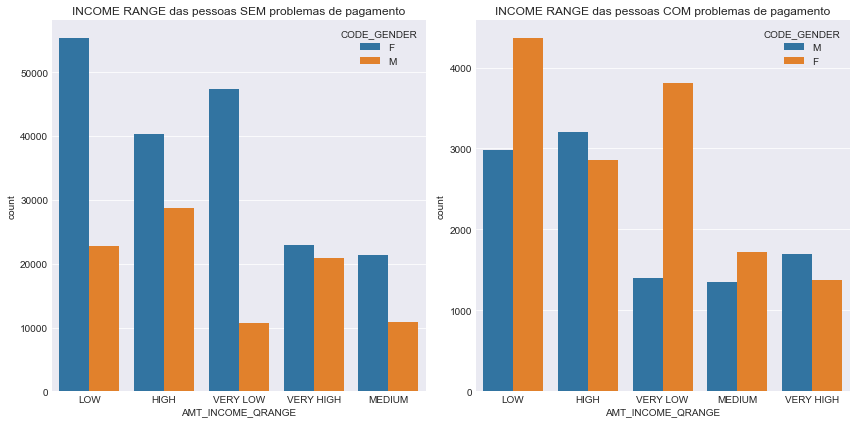

In [46]:
fig, ax =plt.subplots(1,2,figsize=[12,6])
sns.countplot(data=df_target0, x = 'AMT_INCOME_QRANGE', order=df_target0.AMT_INCOME_QRANGE.value_counts().index,hue = 'CODE_GENDER', ax=ax[0])
sns.countplot(data=df_target1, x = 'AMT_INCOME_QRANGE', order=df_target1.AMT_INCOME_QRANGE.value_counts().index,hue = 'CODE_GENDER', ax=ax[1])
ax[0].set_title('INCOME RANGE das pessoas SEM problemas de pagamento')
ax[1].set_title('INCOME RANGE das pessoas COM problemas de pagamento')
fig.tight_layout()
plt.show()

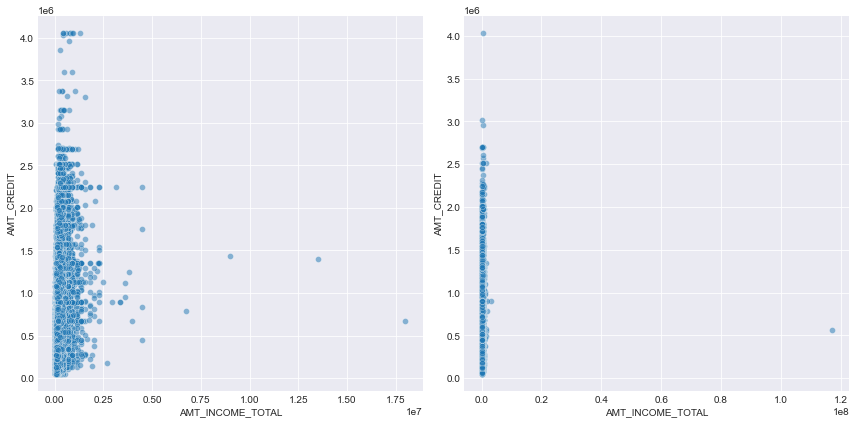

In [47]:
fig, ax =plt.subplots(1,2,figsize=[12,6])
sns.scatterplot(data=df_target0, x='AMT_INCOME_TOTAL', y = 'AMT_CREDIT', alpha=0.5,ax=ax[0])
sns.scatterplot(data=df_target1, x='AMT_INCOME_TOTAL', y = 'AMT_CREDIT', alpha=0.5,ax=ax[1])
fig.tight_layout()
plt.show()

#### PAIRPLOTS

<Figure size 720x432 with 0 Axes>

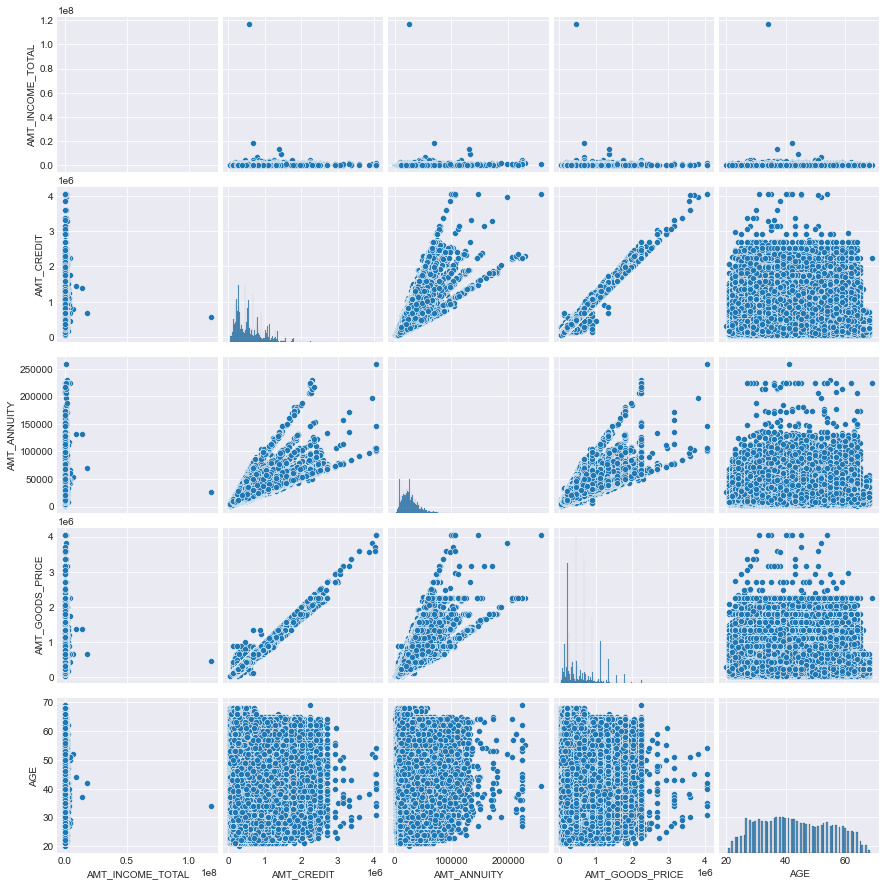

In [48]:
plt.figure(figsize=[10,6])
sns.pairplot(df_clean[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','AGE']])
plt.show()

<Figure size 720x432 with 0 Axes>

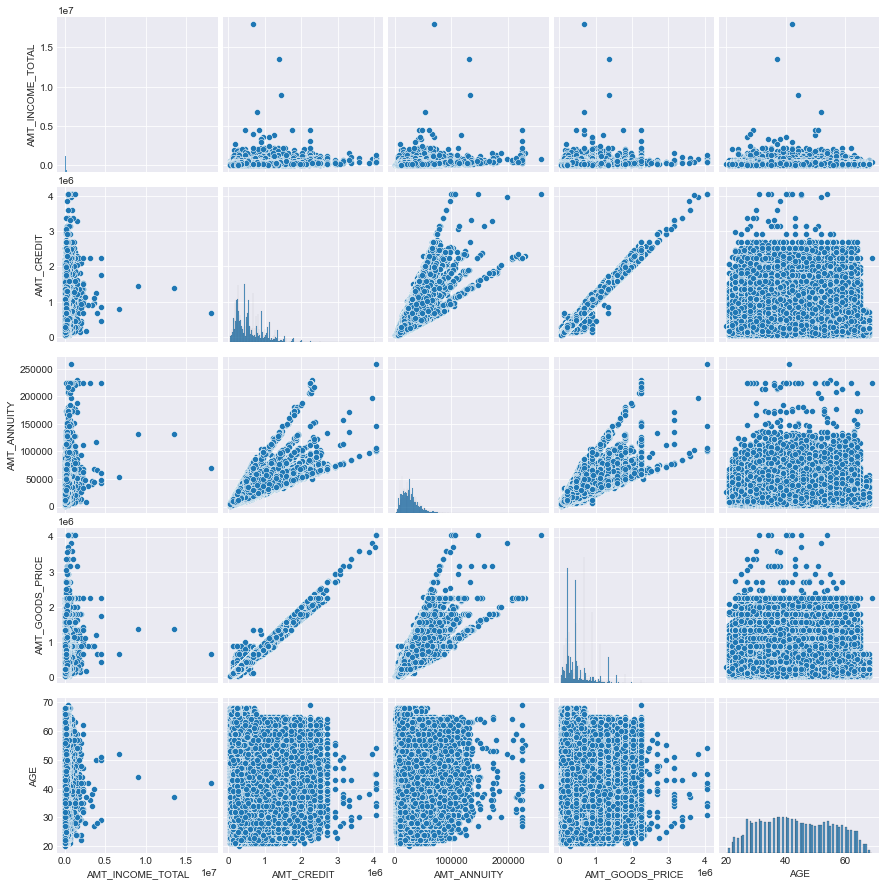

In [49]:
plt.figure(figsize=[10,6])
sns.pairplot(df_target0[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','AGE']])
plt.show()

<Figure size 720x432 with 0 Axes>

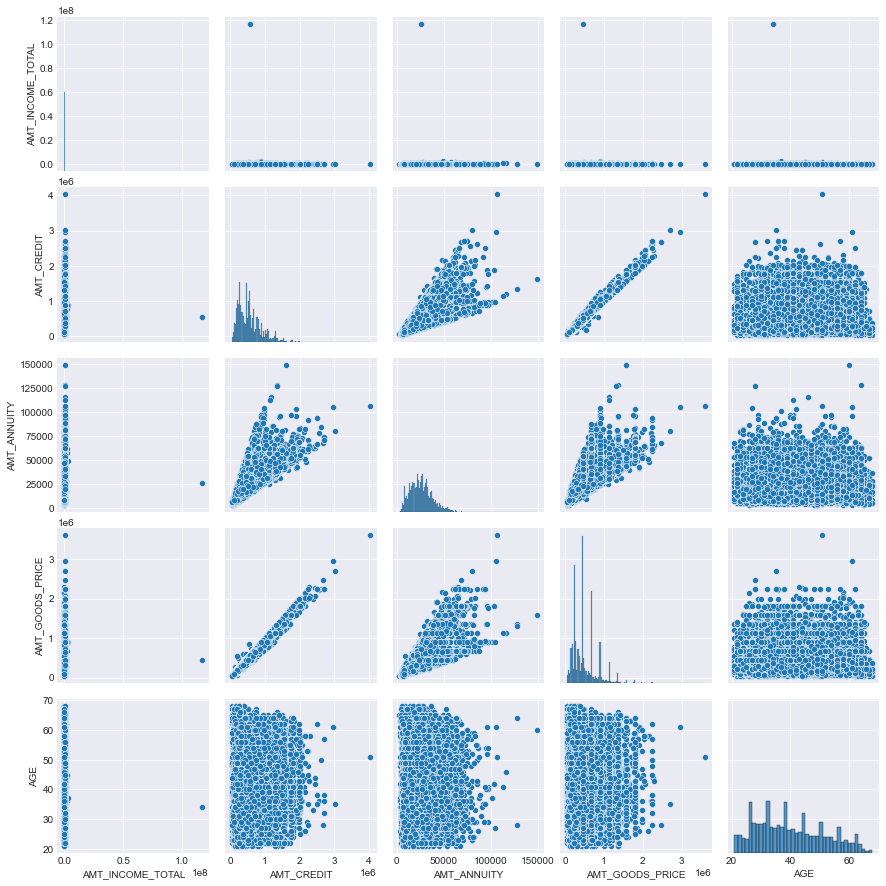

In [50]:
plt.figure(figsize=[10,6])
sns.pairplot(df_target1[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','AGE']])
plt.show()

#### CORRELATION MATRIX

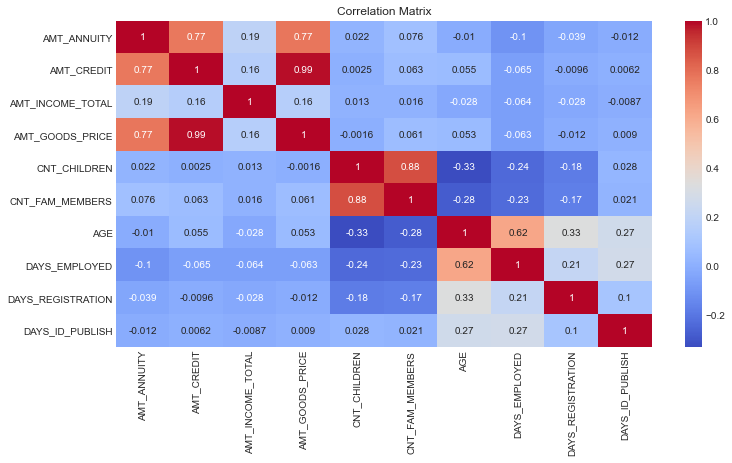

In [51]:
#Printing the correlation matrix
df_corr = df_clean[['AMT_ANNUITY','AMT_CREDIT','AMT_INCOME_TOTAL','AMT_GOODS_PRICE','CNT_CHILDREN','CNT_FAM_MEMBERS',
           'AGE','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']].corr(method='pearson')
plt.figure(figsize=[12,6])
sns.heatmap(data=df_corr, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

## Machine Learning

### Preparation
#### Reloading our clean dataset from before

In [52]:
df_clean = pd.read_csv('postclean.csv.zip')
df_clean.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,CNT_FAM_MEMBERS,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,House / apartment,25,637.0,3648.0,2120.0,1,1.0,0,0,2.0,2.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,House / apartment,45,1188.0,1186.0,291.0,1,2.0,0,0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,52,225.0,4260.0,2531.0,1,1.0,0,0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,52,3039.0,9833.0,2437.0,1,2.0,0,0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,54,3038.0,4311.0,3458.0,1,1.0,0,0,0.0,0.0


#### Final Drops
I´m going to drop the client ID, since it´s not used on the ML phase and features CNT_CHILDREN and AMT_GOODS_PRICE since the correlation with other features are too high.

In [53]:
#Dropping ID 'CNT_CHILDREN','AMT_GOODS_PRICE'
df_clean = df_clean.drop(columns=['SK_ID_CURR', 'AMT_GOODS_PRICE', 'CNT_CHILDREN'], axis = 1)

#### Converting flags to floating values

In [54]:
#Converting Y/N flags to float
df_clean = df_clean.replace({'N': float(0.0), 'Y': float(1.0)})
#Converting Gender F/M flags to float
df_clean = df_clean.replace({'F': float(0.0), 'M': float(1.0)})

#### Factorizing the Education Type

In [55]:
df_clean = df_clean.replace({'Lower secondary': float(0.0), 'Secondary / secondary special': float(1.0),
                            'Incomplete higher': float(2.0), 'Higher education': float(3.0),
                            'Academic degree': float(4.0)})

#### Categorical Variables

In [56]:
df.NAME_CONTRACT_TYPE.unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

In [57]:
df.NAME_INCOME_TYPE.unique()

array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
       'Unemployed', 'Student', 'Businessman', 'Maternity leave'],
      dtype=object)

In [58]:
df.NAME_FAMILY_STATUS.unique()

array(['Single / not married', 'Married', 'Civil marriage', 'Widow',
       'Separated'], dtype=object)

In [59]:
df.NAME_HOUSING_TYPE.unique()

array(['House / apartment', 'Rented apartment', 'With parents',
       'Municipal apartment', 'Office apartment', 'Co-op apartment'],
      dtype=object)

#### OHC

In [60]:
#Converting variables through OHC
colunas = ['NAME_CONTRACT_TYPE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']
cleardata=pd.get_dummies(df_clean, columns=colunas)

In [61]:
cleardata.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_EDUCATION_TYPE,AGE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,CNT_FAM_MEMBERS,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
0,1,1.0,0.0,1.0,202500.0,406597.5,24700.5,1.0,25,637.0,3648.0,2120.0,1,1.0,0,0,2.0,2.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
1,0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,3.0,45,1188.0,1186.0,291.0,1,2.0,0,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,0,1.0,1.0,1.0,67500.0,135000.0,6750.0,1.0,52,225.0,4260.0,2531.0,1,1.0,0,0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0
3,0,0.0,0.0,1.0,135000.0,312682.5,29686.5,1.0,52,3039.0,9833.0,2437.0,1,2.0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0
4,0,1.0,0.0,1.0,121500.0,513000.0,21865.5,1.0,54,3038.0,4311.0,3458.0,1,1.0,0,0,0.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0


In [62]:
cleardata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306196 entries, 0 to 306195
Data columns (total 39 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   TARGET                                   306196 non-null  int64  
 1   CODE_GENDER                              306196 non-null  float64
 2   FLAG_OWN_CAR                             306196 non-null  float64
 3   FLAG_OWN_REALTY                          306196 non-null  float64
 4   AMT_INCOME_TOTAL                         306196 non-null  float64
 5   AMT_CREDIT                               306196 non-null  float64
 6   AMT_ANNUITY                              306196 non-null  float64
 7   NAME_EDUCATION_TYPE                      306196 non-null  float64
 8   AGE                                      306196 non-null  int64  
 9   DAYS_EMPLOYED                            306196 non-null  float64
 10  DAYS_REGISTRATION               

In [63]:
cleardata.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET,306196.0,0.080889,0.272666,0.0,0.0,0.0,0.0,1.0
CODE_GENDER,306196.0,0.341611,0.474251,0.0,0.0,0.0,1.0,1.0
FLAG_OWN_CAR,306196.0,0.340367,0.473833,0.0,0.0,0.0,1.0,1.0
FLAG_OWN_REALTY,306196.0,0.693481,0.461049,0.0,0.0,1.0,1.0,1.0
AMT_INCOME_TOTAL,306196.0,168664.439824,237364.314087,25650.0,112500.0,146250.0,202500.0,117000000.0
AMT_CREDIT,306196.0,599801.234103,402578.563667,45000.0,270000.0,517500.0,808650.0,4050000.0
AMT_ANNUITY,306196.0,27135.130519,14477.434025,1615.5,16573.5,24939.0,34600.5,258025.5
NAME_EDUCATION_TYPE,306196.0,1.508122,0.873835,0.0,1.0,1.0,2.0,4.0
AGE,306196.0,43.413000,11.944607,20.0,33.0,43.0,53.0,69.0
DAYS_EMPLOYED,306196.0,67775.668346,139485.859079,0.0,933.0,2220.0,5714.0,365243.0


### Machine Learning Tests

#### Separating Data

In [64]:
#Separating X, y, train and test data
from sklearn.model_selection import train_test_split
X = cleardata.drop(['TARGET'],axis = 1)
y = cleardata['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42, stratify=y)

#### Financial data
To deal with the huge oultliers, I decided to scale the financial features with the log+1 function

In [65]:
financialcols = ['AMT_INCOME_TOTAL',
                 'AMT_CREDIT',
                 'AMT_ANNUITY']
X_train[financialcols]=X_train[financialcols].apply(np.log1p)

In [66]:
X_test[financialcols]=X_test[financialcols].apply(np.log1p)

#### Scaling Data
I´m going to scale all non-boolean data before firing the ML.

In [67]:
#Importing Scaler
from sklearn.preprocessing import StandardScaler

In [68]:
#Selecting columns to scale
scalecols = ['AMT_INCOME_TOTAL','AMT_CREDIT', 'AMT_ANNUITY','NAME_EDUCATION_TYPE','AGE',
              'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','CNT_FAM_MEMBERS', 'REG_REGION_NOT_LIVE_REGION',
              'REG_CITY_NOT_LIVE_CITY', 'DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE'
           ]

In [69]:
ss = StandardScaler()
X_train[scalecols] = ss.fit_transform(X_train[scalecols])
X_test[scalecols] = ss.fit_transform(X_test[scalecols])

### Testing Models
The models will be tested based on the ROC AUC Score, since it´s a great indicator to separate our predicitions and know if the model is actually working or simply randomly guessing. The TARGET data have huge imbalance, as 90% of the results are TARGET=0.
Every model will be accompanied of the respective Confusion Matrix and final scores. The best model of this first round will be calibrated to ensure a better ROC_AUC Score. Additionally, on some models, I will list the feature importances graph.

In [70]:
#IMPORTS FOR MACHINE LEARNING Metrics
from sklearn.metrics import accuracy_score,roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score

#### Baseline - LogisticRegression

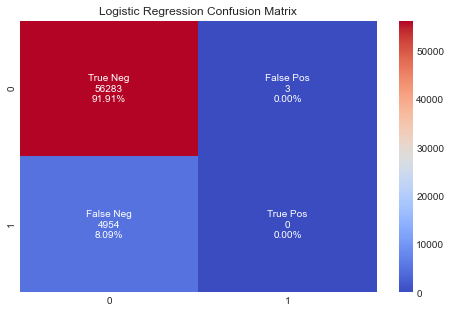

Train Accuracy :  0.919083427227747
Test Accuracy  :  0.9190561724363161
ROC AUC Score  :  0.6483382542049687
Precision Score:  0.0
Recall Score   :  0.0


In [71]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000, n_jobs=-1)
lr.fit(X_train, y_train)
confmetrics(lr,'Logistic Regression Confusion Matrix','LogisticRegression')

#### Decision Tree

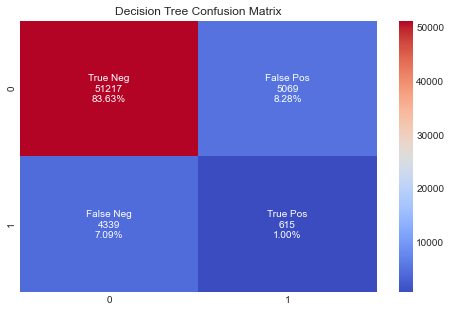

Train Accuracy :  1.0
Test Accuracy  :  0.846374918354017
ROC AUC Score  :  0.517042094450123
Precision Score:  0.1081984517945109
Recall Score   :  0.12414210738796931


In [72]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
confmetrics(dt,'Decision Tree Confusion Matrix','DecisionTree')

[]

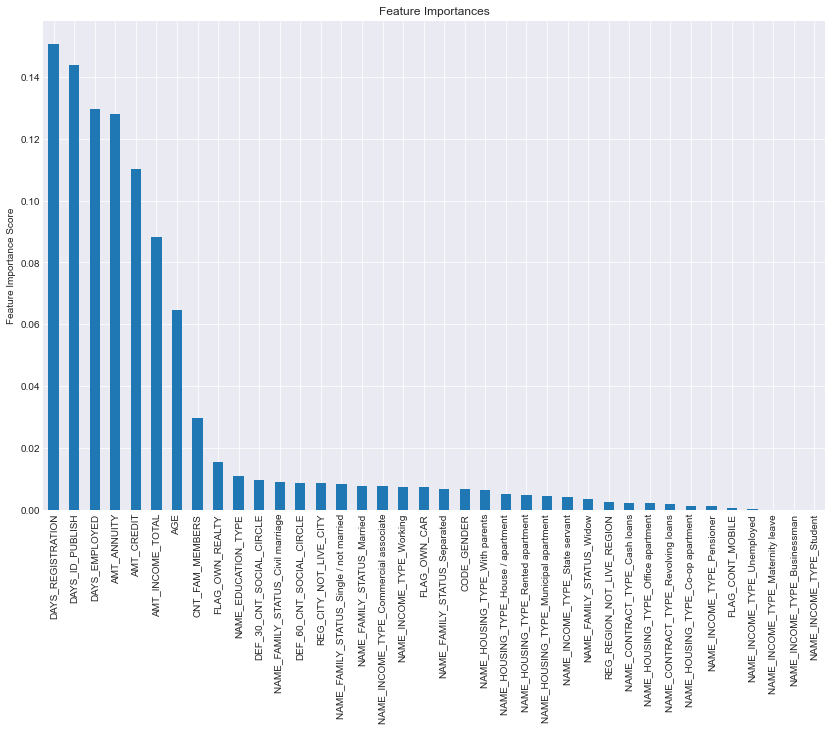

In [73]:
feat_imp = pd.Series(dt.feature_importances_,index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.plot()

#### Naive Bayes

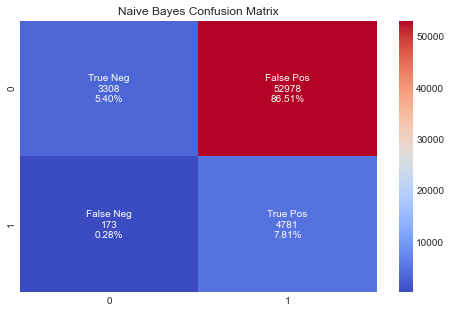

Train Accuracy :  0.13240337040121491
Test Accuracy  :  0.13208687132593078
ROC AUC Score  :  0.6191136223931384
Precision Score:  0.08277497879118406
Recall Score   :  0.9650787242632216


In [74]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
confmetrics(nb,'Naive Bayes Confusion Matrix','GaussianNB')

#### Random Forest

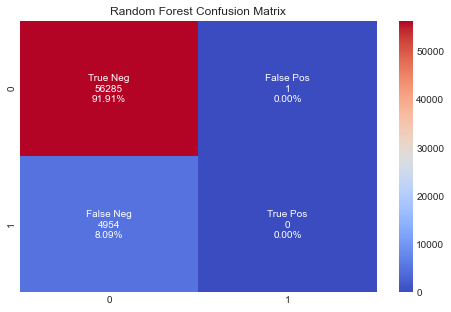

Train Accuracy :  0.9999591763418736
Test Accuracy  :  0.9190888308295232
ROC AUC Score  :  0.6253983526889626
Precision Score:  0.0
Recall Score   :  0.0


In [75]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
confmetrics(rf,'Random Forest Confusion Matrix','RandomForest')

[]

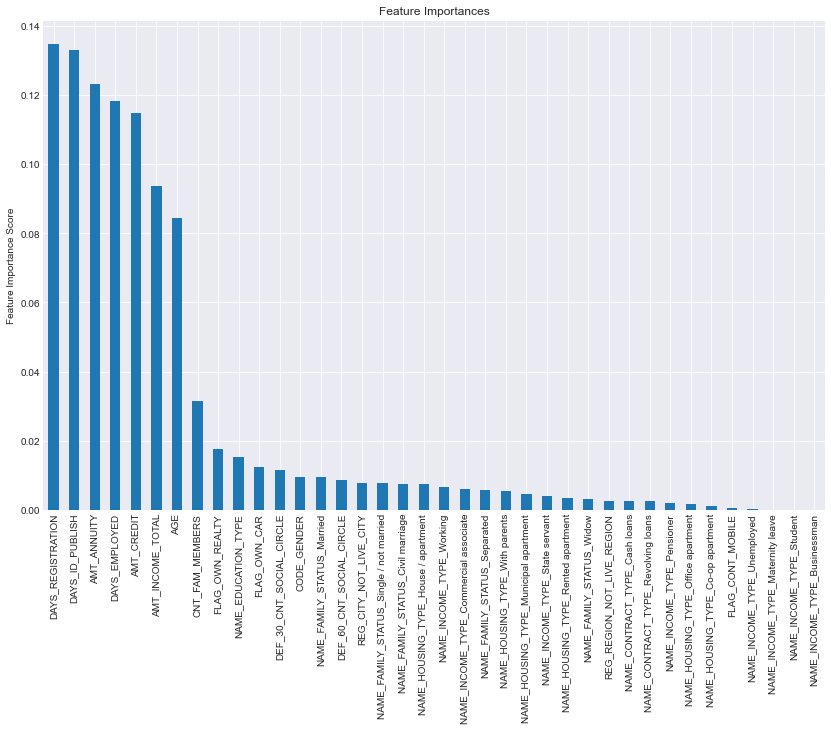

In [76]:
feat_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.plot()

#### XGBoost Classifier

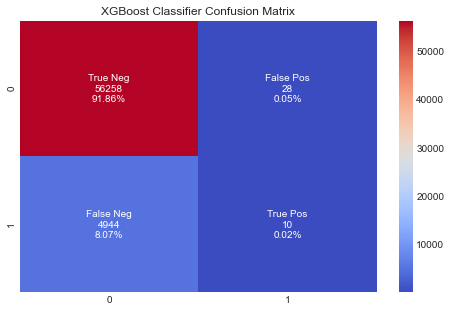

Train Accuracy :  0.9196753702705792
Test Accuracy  :  0.9188112344872632
ROC AUC Score  :  0.6557504556255037
Precision Score:  0.2631578947368421
Recall Score   :  0.0020185708518368995


In [77]:
from xgboost import XGBClassifier
x1 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
x1.fit(X_train, y_train)
confmetrics(x1,'XGBoost Classifier Confusion Matrix','XGBClassifier')

[]

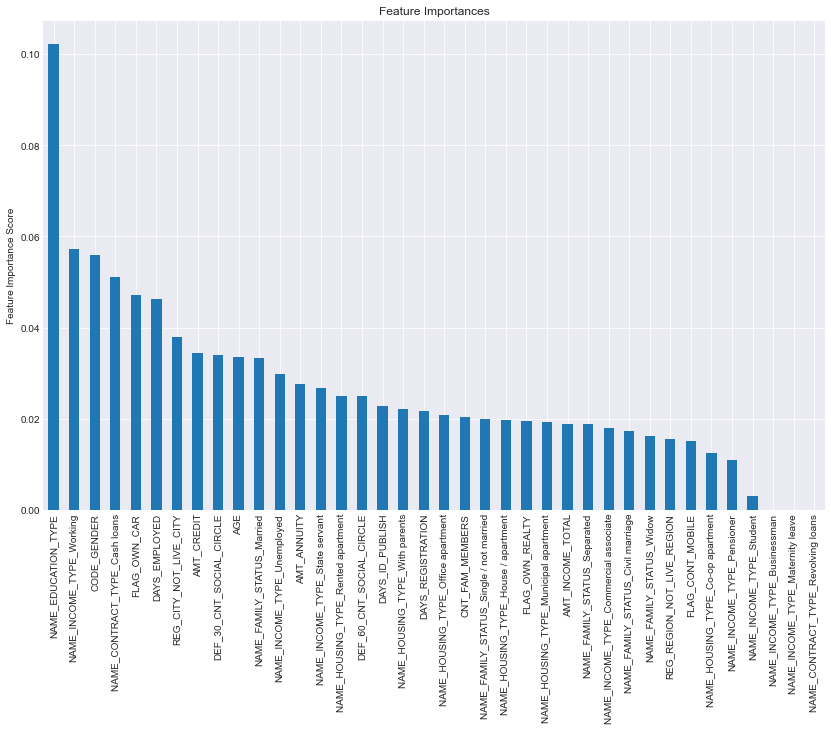

In [78]:
feat_imp = pd.Series(x1.feature_importances_,index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.plot()

#### Scorecard

In [79]:
scorecard

,classifier,train_acc_score,test_acc_score,roc_auc_score,precision,recall,true_neg,false_pos,false_neg,true_pos
0,LogisticRegression,0.919083,0.919056,0.648338,0.000000,0.000000,0.919056,0.000049,0.080895,0.000000
1,DecisionTree,1.000000,0.846375,0.517042,0.108198,0.124142,0.836332,0.082773,0.070852,0.010042
2,GaussianNB,0.132403,0.132087,0.619114,0.082775,0.965079,0.054017,0.865088,0.002825,0.078070
3,RandomForest,0.999959,0.919089,0.625398,0.000000,0.000000,0.919089,0.000016,0.080895,0.000000
4,XGBClassifier,0.919675,0.918811,0.655750,0.263158,0.002019,0.918648,0.000457,0.080732,0.000163


The XGBoost Classifier got the best score, so it will be calibrated by the GridSearchCV

### Calibrating XGBoost Classifier

Due to memory and GPU limitations, I did a few rounds with GSCV to narrow the best parameters. This is an example of my tuning.

In [80]:
# Calibração de modelo
from sklearn.model_selection import GridSearchCV

parameters=[{'learning_rate':[0.1],
             'max_depth':[4,5,6],
             'n_estimators':[200,300,400],
#             'subsample':[0.8],
#             'colsample_bytree':[0.7],
#             'min_child_weight': [0,0.5,1],
#             'reg_alpha':[10],
#             'gamma':[0.5],
            }]
          
xgb = XGBClassifier(objective="binary:logistic", tree_method='gpu_hist', predictor='gpu_predictor', 
                        use_label_encoder=False, n_estimators=100, max_depth=1, eval_metric='logloss')
g1 = GridSearchCV(xgb,parameters,scoring='roc_auc',n_jobs=-1,cv=10)
g1.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=1, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_e..., n_jobs=None,
                                     num_parallel_tree=None,
                                     predictor='gpu_predictor',
                                     random_state=None, reg_alpha=None,
                                   

In [81]:
g1.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 400}

In [82]:
gs1 = g1.best_estimator_

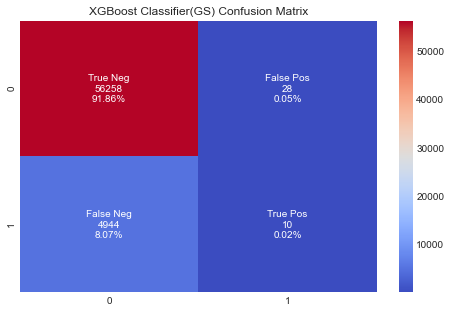

Train Accuracy :  0.9196753702705792
Test Accuracy  :  0.9188112344872632
ROC AUC Score  :  0.6557504556255037
Precision Score:  0.2631578947368421
Recall Score   :  0.0020185708518368995


In [83]:
confmetrics(x1,'XGBoost Classifier(GS) Confusion Matrix')

[]

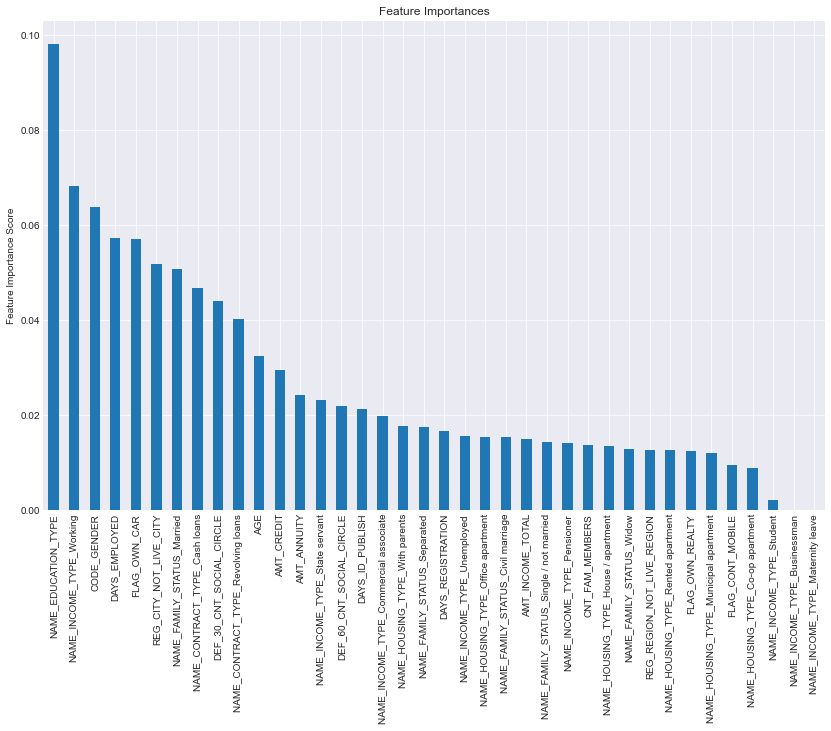

In [84]:
feat_imp = pd.Series(gs1.feature_importances_,index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.plot()

#### After a lot of Hyperparameter tweaking...

In [85]:
xf = XGBClassifier(learning_rate =0.1,
                     n_estimators=373,
                     max_depth=4,
                     min_child_weight=1,
                     gamma=0.5,
                     subsample=0.8,
                     colsample_bytree=0.7,
                     reg_alpha=10,
                     objective= 'binary:logistic',
                     scale_pos_weight=1,
                     tree_method='gpu_hist',
                     predictor='gpu_predictor',
                     use_label_encoder=False,
                     verbosity=0,
                     eval_metric='logloss')

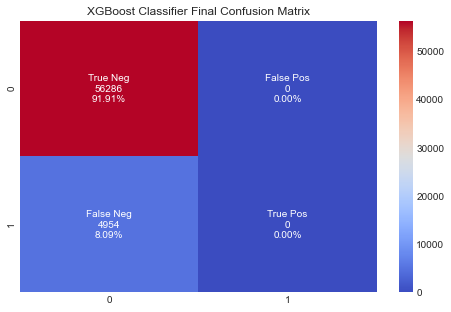

Train Accuracy :  0.9191201685200607
Test Accuracy  :  0.9191051600261267
ROC AUC Score  :  0.6749317524659336
Precision Score:  0.0
Recall Score   :  0.0


In [86]:
xf.fit(X_train, y_train)
confmetrics(xf,'XGBoost Classifier Final Confusion Matrix','XGBClassifier_GS')

[]

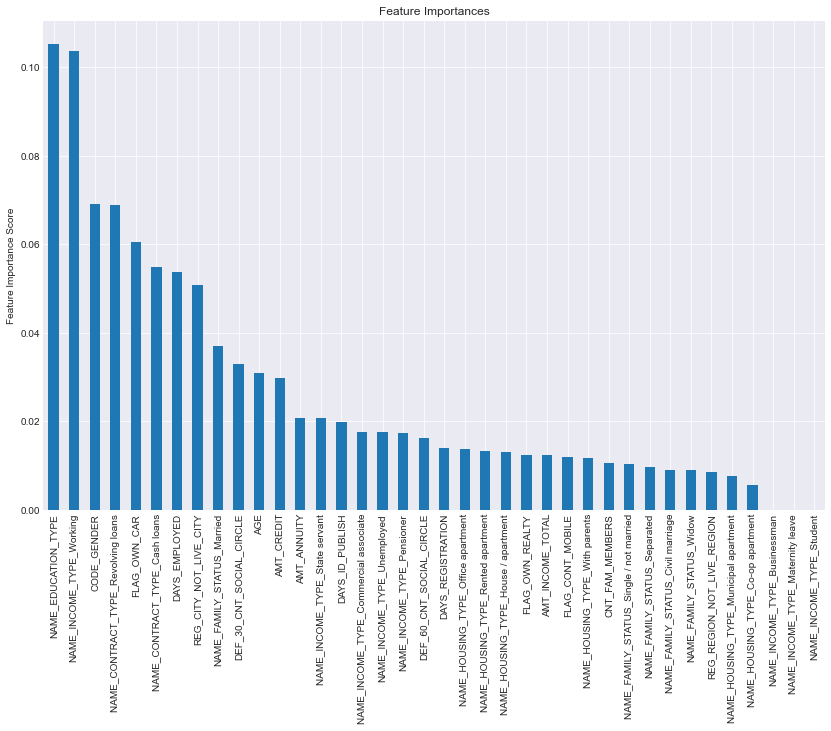

In [87]:
feat_imp = pd.Series(xf.feature_importances_,index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.plot()

In [88]:
scorecard

,classifier,train_acc_score,test_acc_score,roc_auc_score,precision,recall,true_neg,false_pos,false_neg,true_pos
0,LogisticRegression,0.919083,0.919056,0.648338,0.000000,0.000000,0.919056,0.000049,0.080895,0.000000
1,DecisionTree,1.000000,0.846375,0.517042,0.108198,0.124142,0.836332,0.082773,0.070852,0.010042
2,GaussianNB,0.132403,0.132087,0.619114,0.082775,0.965079,0.054017,0.865088,0.002825,0.078070
3,RandomForest,0.999959,0.919089,0.625398,0.000000,0.000000,0.919089,0.000016,0.080895,0.000000
4,XGBClassifier,0.919675,0.918811,0.655750,0.263158,0.002019,0.918648,0.000457,0.080732,0.000163
5,XGBClassifier_GS,0.919120,0.919105,0.674932,0.000000,0.000000,0.919105,0.000000,0.080895,0.000000


## First conclusion and feedback
I managed to squeeze a little more while tuning XGBoost, but it´s not enough to circumvent the imbalance. With these results, the model cannot distinguish false negatives - the most dangerous type in this dataset, as a False Negative means the approval of credit to somebody that will most likely have payment difficulties.

On my first approach, I dropped features to preserve more clients. Now, my approach is to preserve more features.

## Starting Over...

In [89]:
#opening the file
df = pd.read_csv('application_data.zip')

#### Cleaning

In [90]:
#Check for na or missing data
df.isna().sum().sort_values(ascending=False)

COMMONAREA_MEDI                214865
COMMONAREA_AVG                 214865
COMMONAREA_MODE                214865
NONLIVINGAPARTMENTS_MODE       213514
NONLIVINGAPARTMENTS_MEDI       213514
                                ...  
REG_CITY_NOT_LIVE_CITY              0
LIVE_REGION_NOT_WORK_REGION         0
REG_REGION_NOT_WORK_REGION          0
HOUR_APPR_PROCESS_START             0
SK_ID_CURR                          0
Length: 122, dtype: int64

The housing technical info has too many nan values. It has to go.

In [91]:
# Dropping technical info about the housing
coldrops1 = ['APARTMENTS_AVG','BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG',
            'COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG','FLOORSMAX_AVG','FLOORSMIN_AVG',
            'LANDAREA_AVG','LIVINGAPARTMENTS_AVG','LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG',
            'NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE',
            'YEARS_BUILD_MODE','COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE',
            'FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE',
            'NONLIVINGAREA_MODE','APARTMENTS_MEDI','BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI',
            'YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI',
            'FLOORSMIN_MEDI','LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI',
            'NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE','HOUSETYPE_MODE','TOTALAREA_MODE','WALLSMATERIAL_MODE',
            'EMERGENCYSTATE_MODE']
df = df.drop(columns=coldrops1)

In [92]:
df.isna().sum().sort_values(ascending=False)

OWN_CAR_AGE                    202929
EXT_SOURCE_1                   173378
OCCUPATION_TYPE                 96391
EXT_SOURCE_3                    60965
AMT_REQ_CREDIT_BUREAU_QRT       41519
                                ...  
LIVE_REGION_NOT_WORK_REGION         0
REG_REGION_NOT_WORK_REGION          0
REG_REGION_NOT_LIVE_REGION          0
HOUR_APPR_PROCESS_START             0
SK_ID_CURR                          0
Length: 75, dtype: int64

Next I will drop the OWN_CAR_AGE as it has too many NaN values.
The EXT_SOURCE_1 Column has 57% of NaN values, but on further research I discovered that it is rather important on the dataset.
I will try to keep it by filling the values with the median.

In [93]:
df = df.drop(columns='OWN_CAR_AGE')

In [94]:
df.isna().sum().sort_values(ascending=False)

EXT_SOURCE_1                   173378
OCCUPATION_TYPE                 96391
EXT_SOURCE_3                    60965
AMT_REQ_CREDIT_BUREAU_HOUR      41519
AMT_REQ_CREDIT_BUREAU_QRT       41519
                                ...  
LIVE_REGION_NOT_WORK_REGION         0
REG_REGION_NOT_WORK_REGION          0
REG_REGION_NOT_LIVE_REGION          0
HOUR_APPR_PROCESS_START             0
SK_ID_CURR                          0
Length: 74, dtype: int64

In [95]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014568,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,1.000000,1.000

In [96]:
df['EXT_SOURCE_1'] = df['EXT_SOURCE_1'].fillna(df['EXT_SOURCE_1'].median())

In [97]:
df.isna().sum().sort_values(ascending=False)

OCCUPATION_TYPE                96391
EXT_SOURCE_3                   60965
AMT_REQ_CREDIT_BUREAU_YEAR     41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_MON      41519
                               ...  
REG_CITY_NOT_WORK_CITY             0
LIVE_REGION_NOT_WORK_REGION        0
REG_REGION_NOT_WORK_REGION         0
REG_REGION_NOT_LIVE_REGION         0
SK_ID_CURR                         0
Length: 74, dtype: int64

#### Filling Pensioners occupation type and organization type
There´s a catch on the Pensioners data, as they don´t have OCCUPATION and ORGANIZATION TYPE values. I will fill these values.

In [98]:
df['OCCUPATION_TYPE'].loc[(df['OCCUPATION_TYPE'].isnull()) & ((df['NAME_INCOME_TYPE'] == 'Pensioner'))] = 'Pensioner'
df['ORGANIZATION_TYPE'].loc[(df['ORGANIZATION_TYPE'] == 'XNA') & ((df['NAME_INCOME_TYPE'] == 'Pensioner'))] = 'Pensioner'

#### DAYS_EMPLOYED Outlier
There is an outlier in this column. The max value is 365243 and unless this client is immortal, this cannot be possible. I will replace with null to drop later.

In [99]:
df['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [100]:
df['DAYS_EMPLOYED']=df['DAYS_EMPLOYED'].replace(365243, np.nan)

#### Dropping XNA
There are some XNA entries on the ORGANIZATION_TYPE...

In [101]:
df.ORGANIZATION_TYPE.value_counts()

Business Entity Type 3    67992
Pensioner                 55352
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

In [102]:
#Remove XNA ORGANIZATION_TYPE
df = df[df['ORGANIZATION_TYPE'] != 'XNA']

...and a couple XNA on CODE_GENDER

In [103]:
#Remove XNA gender
df = df[df['CODE_GENDER'] != 'XNA']

#### Dropping the rest
Finally, I´ll drop the rest of NaN rows

In [104]:
df = df.dropna()

And I will treat all DAYS_ columns with positive values

In [105]:
#Changing negative values on DAYS collumns
days_cols=[x for x in df if x.startswith('DAYS')] 
df[days_cols]= abs(df[days_cols])

In [106]:
df.shape

(167735, 74)

In [107]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,167735.0,278195.069604,102906.454766,100002.0,188911.5,278120.0,367501.0,456255.0
TARGET,167735.0,0.084699,0.278434,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,167735.0,0.512630,0.769456,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,167735.0,179106.927883,304334.311451,26550.0,112500.0,157500.0,225000.0,117000000.0
AMT_CREDIT,167735.0,620564.681104,408046.338819,45000.0,284400.0,528633.0,835605.0,4050000.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,167735.0,0.006767,0.109613,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,167735.0,0.034060,0.202091,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,167735.0,0.289188,0.962499,0.0,0.0,0.0,0.0,24.0
AMT_REQ_CREDIT_BUREAU_QRT,167735.0,0.258026,0.601808,0.0,0.0,0.0,0.0,8.0


I have more features to pass for my ML models now, at a cost of a third of my data.

In [108]:
#Exporting
df.to_csv('toml.csv.zip', index=False, compression='zip')

## Second Machine Learning preparations

This time, I will change the approach for the ML, as I´m dealing with more categorical features. I will use the CatBoost Classifier. CatBoost already have its own treatment for categorical variables.

In [109]:
df_clean = pd.read_csv('toml.csv.zip')

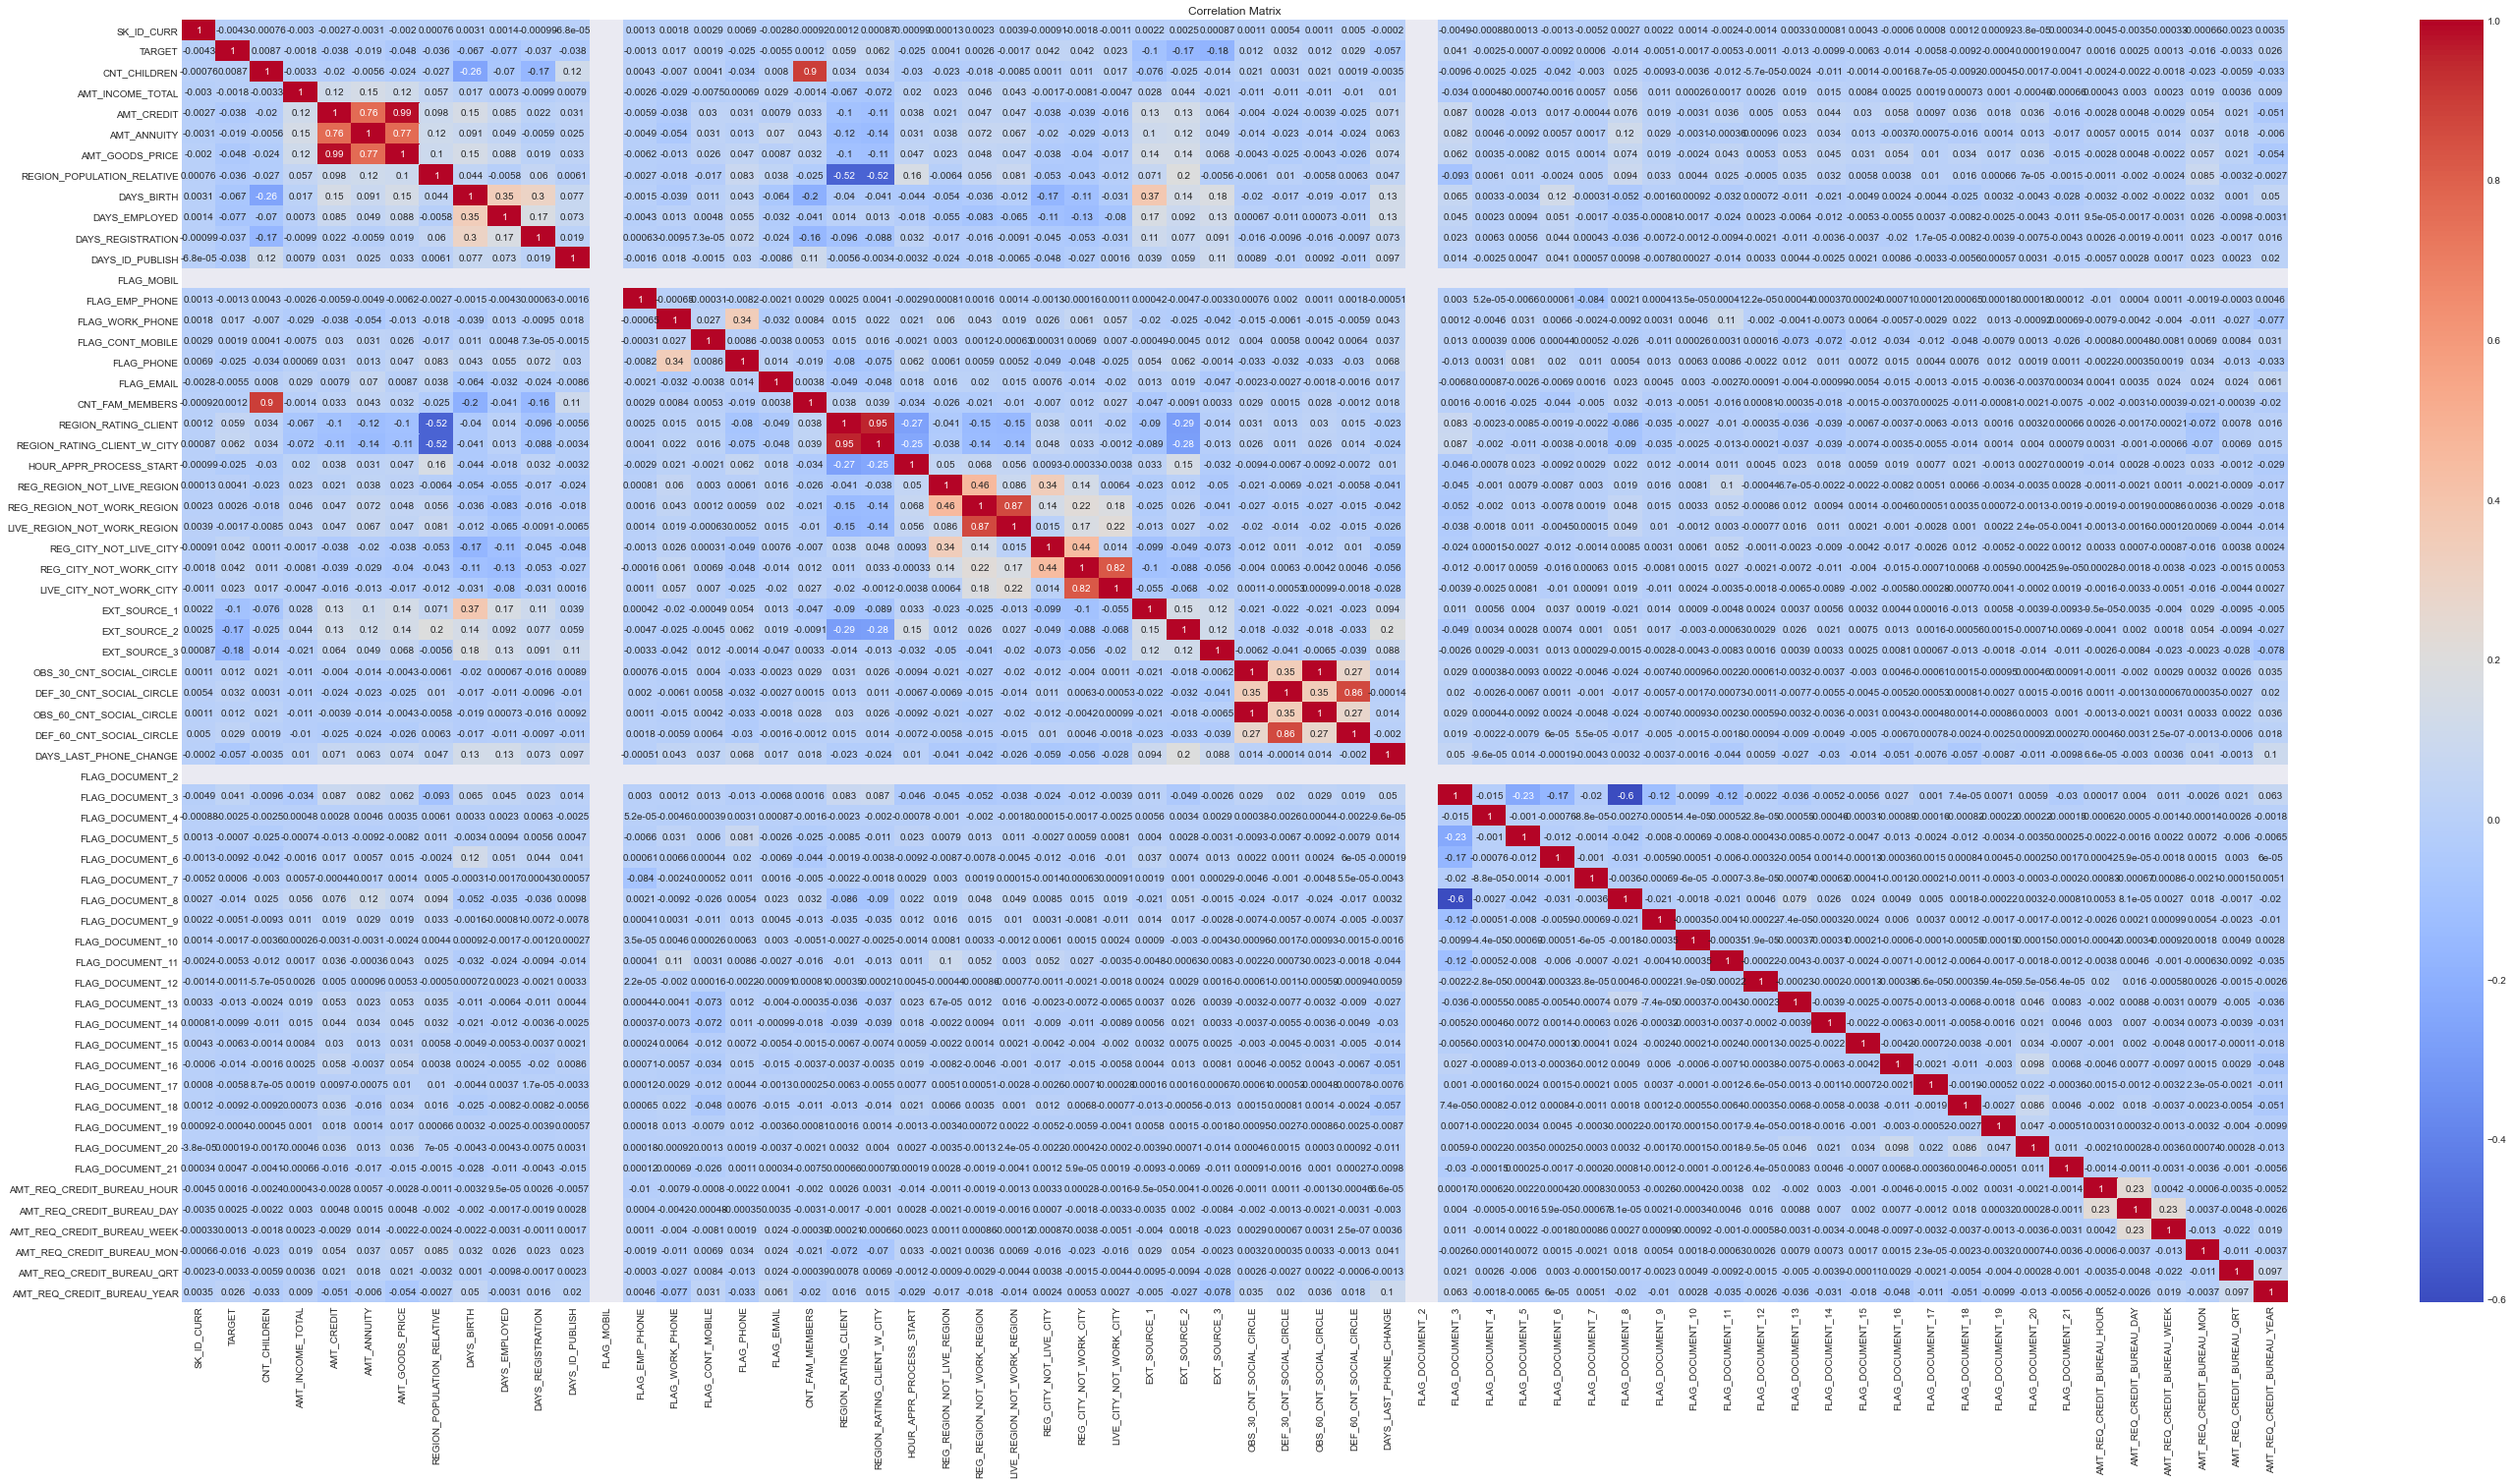

In [110]:
#Printing the correlation matrix
df_corr = df_clean.corr(method='pearson')
plt.figure(figsize=[48,24])
sns.heatmap(data=df_corr, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

It is a huge correlation matrix, but there´s 3 pairs with high correlation(over 95%). I will drop the columns REGION_RATING_CLIENT_W_CITY, AMT_GOODS_PRICE and OBS_30_CNT_SOCIAL_CIRCLE along with the ID.

In [111]:
#Drop the ID and high corr columns.
df_clean = df_clean.drop(columns=['SK_ID_CURR','REGION_RATING_CLIENT_W_CITY', 'AMT_GOODS_PRICE','OBS_30_CNT_SOCIAL_CIRCLE'], axis=1)

In [112]:
#Converting Y/N flags to float
df_clean = df_clean.replace({'N': float(0.0), 'Y': float(1.0)})
#Converting Gender F/M flags to float
df_clean = df_clean.replace({'F': float(0.0), 'M': float(1.0)})

In [113]:
#Factorizing the Education type
df_clean = df_clean.replace({'Lower secondary': float(0.0), 'Secondary / secondary special': float(1.0),
                            'Incomplete higher': float(2.0), 'Higher education': float(3.0),
                            'Academic degree': float(4.0)})

#### Separating Data

In [114]:
#Separating X, y, train and test data
cleardata = df_clean
from sklearn.model_selection import train_test_split
X = cleardata.drop(['TARGET'],axis = 1)
y = cleardata['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42, stratify=y)

In [115]:
y_test.value_counts()

0    30706
1     2841
Name: TARGET, dtype: int64

I still have this huge inbalance, but I hope the added features result in an increased roc_auc_score

In [116]:
scalethis = ['CNT_CHILDREN',
             'AMT_INCOME_TOTAL',
             'AMT_CREDIT',
             'AMT_ANNUITY',
             'REGION_POPULATION_RELATIVE',
             'DAYS_BIRTH',
             'DAYS_EMPLOYED',
             'DAYS_REGISTRATION',
             'DAYS_ID_PUBLISH',
             'CNT_FAM_MEMBERS',
             'REGION_RATING_CLIENT',
             'HOUR_APPR_PROCESS_START',
             'REG_REGION_NOT_LIVE_REGION',
             'REG_REGION_NOT_WORK_REGION',
             'LIVE_REGION_NOT_WORK_REGION',
             'REG_CITY_NOT_LIVE_CITY',
             'REG_CITY_NOT_WORK_CITY',
             'LIVE_CITY_NOT_WORK_CITY',
             'EXT_SOURCE_1',
             'EXT_SOURCE_2',
             'EXT_SOURCE_3',
             'DEF_30_CNT_SOCIAL_CIRCLE',
             'OBS_60_CNT_SOCIAL_CIRCLE',
             'DEF_60_CNT_SOCIAL_CIRCLE',
             'DAYS_LAST_PHONE_CHANGE',
             'AMT_REQ_CREDIT_BUREAU_HOUR',
             'AMT_REQ_CREDIT_BUREAU_DAY',
             'AMT_REQ_CREDIT_BUREAU_WEEK',
             'AMT_REQ_CREDIT_BUREAU_MON',
             'AMT_REQ_CREDIT_BUREAU_QRT',
             'AMT_REQ_CREDIT_BUREAU_YEAR',
]
ss = StandardScaler()
ss.fit(X_train[scalethis])
X_train[scalethis] = ss.transform(X_train[scalethis])
X_test[scalethis] = ss.transform(X_test[scalethis])

### CatBoost

In [117]:
!pip install catboost

In [118]:
#Separating the categorical features
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_features_indices

array([ 0,  8,  9, 11, 12, 18, 19, 20, 21, 22, 23, 24, 27, 35, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62],
      dtype=int64)

#### First CatBoost run

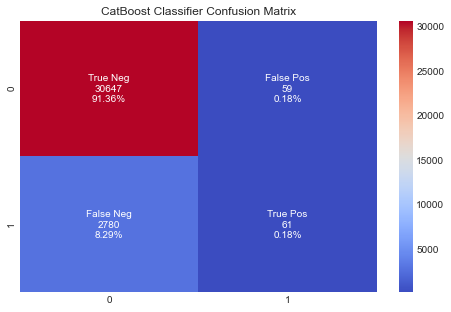

Train Accuracy :  0.9183682594568814
Test Accuracy  :  0.915372462515277
ROC AUC Score  :  0.7600404999115844
Precision Score:  0.5083333333333333
Recall Score   :  0.021471312917986624


In [119]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(task_type='GPU', one_hot_max_size=255, cat_features=categorical_features_indices, logging_level='Silent')
cb.fit(X_train, y_train)
confmetrics(cb,'CatBoost Classifier Confusion Matrix','CatBoost')

[]

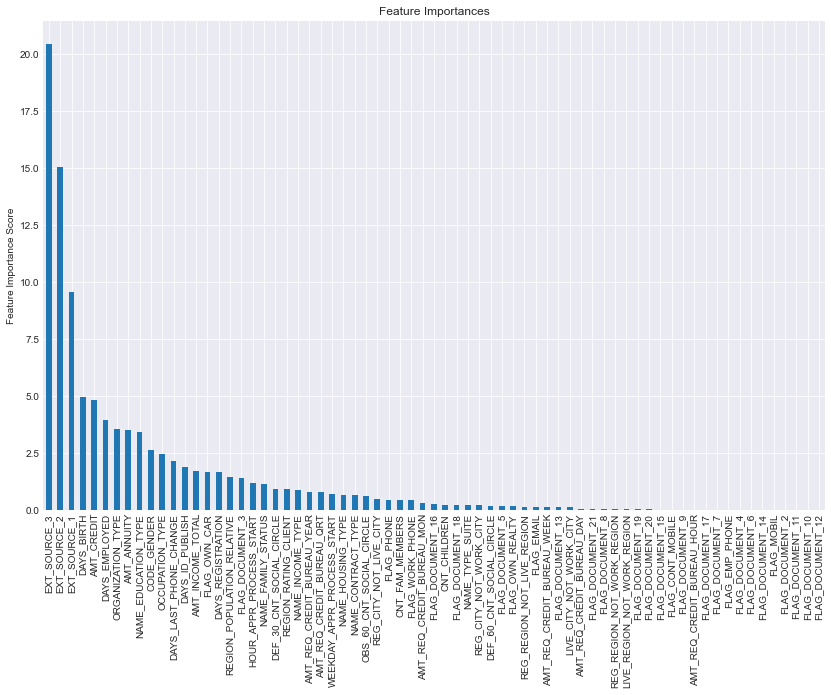

In [120]:
feat_imp = pd.Series(cb.feature_importances_,index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.plot()

In [121]:
scorecard

,classifier,train_acc_score,test_acc_score,roc_auc_score,precision,recall,true_neg,false_pos,false_neg,true_pos
0,LogisticRegression,0.919083,0.919056,0.648338,0.000000,0.000000,0.919056,0.000049,0.080895,0.000000
1,DecisionTree,1.000000,0.846375,0.517042,0.108198,0.124142,0.836332,0.082773,0.070852,0.010042
2,GaussianNB,0.132403,0.132087,0.619114,0.082775,0.965079,0.054017,0.865088,0.002825,0.078070
3,RandomForest,0.999959,0.919089,0.625398,0.000000,0.000000,0.919089,0.000016,0.080895,0.000000
4,XGBClassifier,0.919675,0.918811,0.655750,0.263158,0.002019,0.918648,0.000457,0.080732,0.000163
5,XGBClassifier_GS,0.919120,0.919105,0.674932,0.000000,0.000000,0.919105,0.000000,0.080895,0.000000
6,CatBoost,0.918368,0.915372,0.760040,0.508333,0.021471,0.913554,0.001759,0.082869,0.001818


The changes on feature selection had a good impact on the roc_auc_score. Let´s see if I can squeeze a little more performance.

#### Calibrating CatBoost
As I said before, due to technical limitations, I had to do a few rounds testing hyperparameters. This is the last iteraction.

In [122]:
# Calibração de modelo
parameters=[{'learning_rate':[0.1],
             'depth':[4],
             'iterations':[635],
             'l2_leaf_reg':[5],
             'random_strength': [0.1],
             'bagging_temperature':[0.01],
             'max_ctr_complexity':[1],
             'scale_pos_weight':[1],}]
          
cat = CatBoostClassifier(one_hot_max_size=255, cat_features=categorical_features_indices, logging_level='Silent')
g2 = GridSearchCV(cat,parameters,scoring='roc_auc',n_jobs=-1,cv=10)
g2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000015F25276DF0>,
             n_jobs=-1,
             param_grid=[{'bagging_temperature': [0.01], 'depth': [4],
                          'iterations': [635], 'l2_leaf_reg': [5],
                          'learning_rate': [0.1], 'max_ctr_complexity': [1],
                          'random_strength': [0.1], 'scale_pos_weight': [1]}],
             scoring='roc_auc')

In [123]:
g2.best_params_

{'bagging_temperature': 0.01,
 'depth': 4,
 'iterations': 635,
 'l2_leaf_reg': 5,
 'learning_rate': 0.1,
 'max_ctr_complexity': 1,
 'random_strength': 0.1,
 'scale_pos_weight': 1}

In [124]:
gs2 = g2.best_estimator_

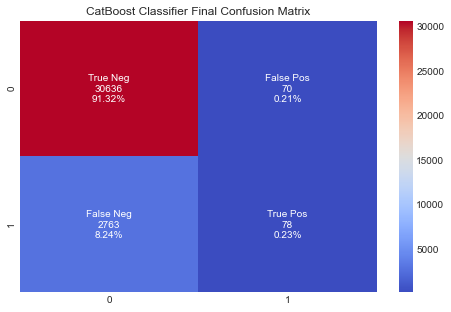

Train Accuracy :  0.9185173040808418
Test Accuracy  :  0.9155513160640296
ROC AUC Score  :  0.7603274121138369
Precision Score:  0.527027027027027
Recall Score   :  0.027455121436114043


In [125]:
confmetrics(gs2,'CatBoost Classifier Final Confusion Matrix','CatBoost_GS')

[]

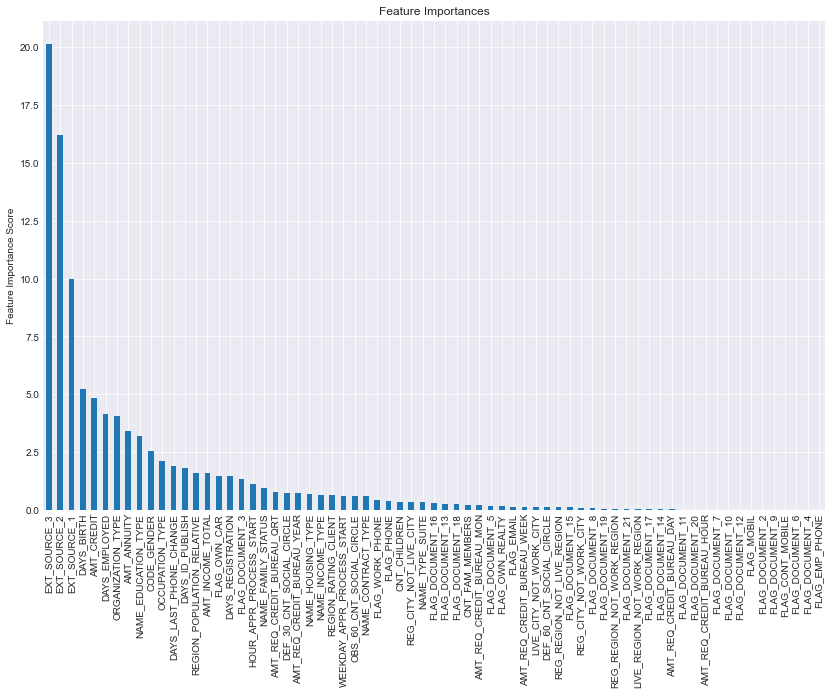

In [126]:
feat_imp = pd.Series(gs2.feature_importances_,index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.plot()

## Final Scores and conclusion

In [127]:
scorecard.round(4)

,classifier,train_acc_score,test_acc_score,roc_auc_score,precision,recall,true_neg,false_pos,false_neg,true_pos
0,LogisticRegression,0.9191,0.9191,0.6483,0.0000,0.0000,0.9191,0.0000,0.0809,0.0000
1,DecisionTree,1.0000,0.8464,0.5170,0.1082,0.1241,0.8363,0.0828,0.0709,0.0100
2,GaussianNB,0.1324,0.1321,0.6191,0.0828,0.9651,0.0540,0.8651,0.0028,0.0781
3,RandomForest,1.0000,0.9191,0.6254,0.0000,0.0000,0.9191,0.0000,0.0809,0.0000
4,XGBClassifier,0.9197,0.9188,0.6558,0.2632,0.0020,0.9186,0.0005,0.0807,0.0002
5,XGBClassifier_GS,0.9191,0.9191,0.6749,0.0000,0.0000,0.9191,0.0000,0.0809,0.0000
6,CatBoost,0.9184,0.9154,0.7600,0.5083,0.0215,0.9136,0.0018,0.0829,0.0018
7,CatBoost_GS,0.9185,0.9156,0.7603,0.5270,0.0275,0.9132,0.0021,0.0824,0.0023


The changes in feature selection and the use of catboost greatly improved the score.
Unfortunately it is not enough to get rid of the False Negative values on this dataset, but it is good enough for now. 
Due to this ML exercise, we can reduce the human work needed to analyze the applications, focusing only in a way small amount of requests instead manually analyze all applications.